## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook. 

In [2]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
#Model
from sklearn.ensemble import RandomForestRegressor



sns.set()

In [3]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [4]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y[lag:].flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [5]:
def createLagFeature(name_features,lag,df):
    for name_feature in name_features:
        for i in range(1,lag+1):
            df[name_feature+"lag"+str(i)]=df[name_feature].shift(i)
    return df

---

## Cargar y preparar los datos.

In [3]:
df = pd.read_csv("../../Datasets/Datos_durante_pandemia/data_durante_vol_in.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Vol. Futuros': 'VolFuturos'})
df

Fecha  VolFuturos        VIX  EMV-ID     EPU
0   2020-01-01    1.289946  12.548403    1.89  186.06
1   2020-01-02    0.735046  12.470000    2.84  139.13
2   2020-01-03    0.591834  14.020000    1.33  108.10
3   2020-01-04    1.367154  14.646666    0.00  212.82
4   2020-01-05    1.505321  14.311970    0.86  173.76
..         ...         ...        ...     ...     ...
913 2022-07-02    0.778572  25.922916   11.11  130.95
914 2022-07-03    0.819483  26.641413   23.06  135.95
915 2022-07-04    0.843804  27.530000   15.98  309.83
916 2022-07-05    0.850985  27.540000   18.90  116.59
917 2022-07-06    0.840437  26.730000    2.27   91.52

[918 rows x 5 columns]

---

## Desarrollo del modelo

In [7]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [8]:
df_stats=df

In [9]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["VolFuturos"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
#df_label=sc.fit_transform(df_label)
#df_data_normalize=sc2.fit_transform(df_data)


In [10]:
def Model(df_data,df_label,lag,estimators):
    
    df_data_lags=createLagFeature(df_data.columns,lag,df_data) if lag>0 else df_data
    df_data_lags.drop(columns="VolFuturos",inplace=True)
    df_data_lags=df_data_lags[lag:]
    #transform data
    df_data_lags=sc2.fit_transform(df_data_lags)
    
    #split data
    #last index of the train data
    seventy_percent=int(len_data*0.7)

    #split the data normalize
    
    df_train=df_data_lags[:seventy_percent]
    df_test=df_data_lags[seventy_percent:]

    #split labels
    df_label=df_label[lag:]
    df_train_y=df_label[:seventy_percent]
    df_test_y=df_label[seventy_percent:]
    #split labels normalize
    
    df_label_normalize=sc.fit_transform(df_label)
    df_train_y_normalize=df_label_normalize[:seventy_percent]
    df_test_y_normalize=df_label_normalize[seventy_percent:]
    print(df_test_y_normalize.shape)
    print(df_test.shape)


    #make model
    model=RandomForestRegressor(n_estimators=estimators)
    #fit the model with the train data
    history=model.fit(df_train,df_train_y_normalize)
   
    # make predictions
    trainPredict = model.predict(df_train)
    trainPredict = np.reshape(trainPredict,(len(trainPredict),1))
    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    testPredict = model.predict(df_test)
    # invert transformation
    testPredict = np.reshape(testPredict,(len(testPredict),1))
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    print("len test: ",testY.shape)
    print("len PREDICT: ",testPredict.shape)
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    return [{"Fecha":df_stats.Fecha[lag:][:seventy_percent],"typeRandomForest":["train"]*len(trainPredict.flatten()),"RandomForest" :trainPredict.flatten()}
            ,{"Fecha":df_stats.Fecha[lag:][seventy_percent:],"typeRandomForest":["test"]*len(testPredict.flatten()),"RandomForest":testPredict.flatten()}]

    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()+1, testPredict.flatten()+1,False)}

## Resultados 

(273, 1)
(273, 15)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.2355323167830222
MAE is : 0.3445239064306606
RMSE is : 0.4853167180131158
MAPE is : 16.76538598264211
Evaluation metric results:
MSE is : 1.3305339100516336
MAE is : 0.8762471694588272
RMSE is : 1.1534877156049965
MAPE is : 43.36125687904773
(273, 1)
(273, 15)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.22537793730694639
MAE is : 0.3444860367022385
RMSE is : 0.4747398627742844
MAPE is : 16.677778768273786
Evaluation metric results:
MSE is : 1.3803499484405504
MAE is : 0.8957127562389283
RMSE is : 1.1748829509532217
MAPE is : 43.906573144784495
(273, 1)
(273, 15)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.2253110220484399
MAE is : 0.34029581593549585
RMSE is : 0.4746693818316491
MAPE is : 16.39634480389058
Evaluation metric results:
MSE is : 1.367310109501239
MAE is : 0.8766745440528773
RMSE is : 1.1693203622195412
MAPE is : 43.03115787585256
(273, 1)
(273, 15)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.22026319136417793
MAE is : 0.33800696386214685
RMSE is : 0.469322055058334
MAPE is : 16.437966319807497
Evaluation metric results:
MSE is : 1.3453822287838975
MAE is : 0.8812231583328977
RMSE is : 1.1599061292983572
MAPE is : 43.38509223304902
(273, 1)
(273, 15)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.22512237168080346
MAE is : 0.33756271413326955
RMSE is : 0.47447062256877764
MAPE is : 16.345979542660725
Evaluation metric results:
MSE is : 1.3468595549244766
MAE is : 0.8761301557073397
RMSE is : 1.1605427846160936
MAPE is : 42.97264307689685
(271, 1)
(271, 23)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.24251333709781375
MAE is : 0.34785194883816195
RMSE is : 0.49245643167473585
MAPE is : 17.038723130527693
Evaluation metric results:
MSE is : 1.412873004906057
MAE is : 0.8974691714233716
RMSE is : 1.1886433463853052
MAPE is : 43.64702497655987
(271, 1)
(271, 23)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.23085124626610146
MAE is : 0.34004270149820937
RMSE is : 0.48046981826760093
MAPE is : 16.467815118480793
Evaluation metric results:
MSE is : 1.37914273673519
MAE is : 0.8815119833703263
RMSE is : 1.1743690802874496
MAPE is : 43.557333573101516
(271, 1)
(271, 23)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.21847196324149673
MAE is : 0.33564602015041717
RMSE is : 0.4674098450412622
MAPE is : 16.320754066526664
Evaluation metric results:
MSE is : 1.3703819865328668
MAE is : 0.8722522507278299
RMSE is : 1.1706331562589822
MAPE is : 42.571587867933594
(271, 1)
(271, 23)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.22086321493141142
MAE is : 0.33698939288318036
RMSE is : 0.46996086531903
MAPE is : 16.405762133687404
Evaluation metric results:
MSE is : 1.385751763983553
MAE is : 0.8814328984553168
RMSE is : 1.177179580176089
MAPE is : 43.12664370750171
(271, 1)
(271, 23)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.2118771561785425
MAE is : 0.33456008764881207
RMSE is : 0.4603011581329581
MAPE is : 16.39428505741172
Evaluation metric results:
MSE is : 1.367084892440934
MAE is : 0.876991569020862
RMSE is : 1.1692240557057205
MAPE is : 42.90772042361123
(269, 1)
(269, 31)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.22306267649664682
MAE is : 0.3393668053688787
RMSE is : 0.47229511589328005
MAPE is : 16.217053935380836
Evaluation metric results:
MSE is : 1.3604469599227753
MAE is : 0.8923166531036114
RMSE is : 1.1663819957127148
MAPE is : 43.338705041830835


<ipython-input-5-f7487097fa4e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=[15,8])


(269, 1)
(269, 31)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.22632168882731551
MAE is : 0.3394800023446795
RMSE is : 0.4757327914147978
MAPE is : 16.46158967043398
Evaluation metric results:
MSE is : 1.3192100984354143
MAE is : 0.8612468872662639
RMSE is : 1.1485687173327568
MAPE is : 42.00531558027075
(269, 1)
(269, 31)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.21628911415052407
MAE is : 0.3363579960337806
RMSE is : 0.46506893483711
MAPE is : 16.42007265055199
Evaluation metric results:
MSE is : 1.3037566733355355
MAE is : 0.8549646997122302
RMSE is : 1.1418216469026743
MAPE is : 41.63555258841555
(269, 1)
(269, 31)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.22251071827361435
MAE is : 0.3378873517225642
RMSE is : 0.4717104178133173
MAPE is : 16.41900119280922
Evaluation metric results:
MSE is : 1.3151073028340472
MAE is : 0.8599271660392401
RMSE is : 1.1467812794225616
MAPE is : 42.000106491260105
(269, 1)
(269, 31)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.21938025061352487
MAE is : 0.3402719090521481
RMSE is : 0.4683804549866752
MAPE is : 16.594726356337024
Evaluation metric results:
MSE is : 1.33320804041625
MAE is : 0.868127104051002
RMSE is : 1.154646283680093
MAPE is : 42.29621072265463
(268, 1)
(268, 35)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.24712129811569095
MAE is : 0.3464670364050111
RMSE is : 0.4971129631338243
MAPE is : 16.686306665620982
Evaluation metric results:
MSE is : 1.3598684561179437
MAE is : 0.8726595031760771
RMSE is : 1.1661339786310765
MAPE is : 42.462040634011416
(268, 1)
(268, 35)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.2328644672314213
MAE is : 0.34379949603810855
RMSE is : 0.48256032496613444
MAPE is : 16.70635188113173
Evaluation metric results:
MSE is : 1.343238680648246
MAE is : 0.870828184527863
RMSE is : 1.1589817430176568
MAPE is : 42.885965920530325
(268, 1)
(268, 35)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.23216010876604373
MAE is : 0.3447850588074907
RMSE is : 0.4818299583525746
MAPE is : 16.836517821677145
Evaluation metric results:
MSE is : 1.3261712716037468
MAE is : 0.8672510804885387
RMSE is : 1.1515950988102315
MAPE is : 42.87632519506859
(268, 1)
(268, 35)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.22423715001096411
MAE is : 0.3400801844018859
RMSE is : 0.4735368517982145
MAPE is : 16.761538894493818
Evaluation metric results:
MSE is : 1.3385822751229932
MAE is : 0.8719000534730084
RMSE is : 1.1569711643437761
MAPE is : 42.81354472862545
(268, 1)
(268, 35)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.22573884294809243
MAE is : 0.3413145647946196
RMSE is : 0.4751198195698559
MAPE is : 16.720090181360383
Evaluation metric results:
MSE is : 1.343181457247884
MAE is : 0.8739922771349096
RMSE is : 1.1589570558255746
MAPE is : 43.059446806240125
(266, 1)
(266, 43)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.2383518652185776
MAE is : 0.3441320093830632
RMSE is : 0.4882129302042067
MAPE is : 16.5237112007525
Evaluation metric results:
MSE is : 1.3719351399391895
MAE is : 0.8879966663478562
RMSE is : 1.1712963501775242
MAPE is : 44.15250409748985
(266, 1)
(266, 43)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.2243920077557498
MAE is : 0.3412747881648196
RMSE is : 0.47370033539754836
MAPE is : 16.7370824514716
Evaluation metric results:
MSE is : 1.327256023865874
MAE is : 0.8668421598586308
RMSE is : 1.1520659806911555
MAPE is : 42.501944538261924
(266, 1)
(266, 43)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.23184965417542358
MAE is : 0.33653468086384
RMSE is : 0.48150768859429816
MAPE is : 16.316722548827258
Evaluation metric results:
MSE is : 1.3209401939738448
MAE is : 0.8729985562233222
RMSE is : 1.149321623382178
MAPE is : 43.143361969736084
(266, 1)
(266, 43)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.22567831479064523
MAE is : 0.3336293221035526
RMSE is : 0.4750561175173363
MAPE is : 16.316771074398247
Evaluation metric results:
MSE is : 1.311429476180837
MAE is : 0.865361525275653
RMSE is : 1.1451766135320949
MAPE is : 42.70905567630206
(266, 1)
(266, 43)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.2206214961945639
MAE is : 0.33543817377488877
RMSE is : 0.4697036259116635
MAPE is : 16.38962774922332
Evaluation metric results:
MSE is : 1.3421107770905212
MAE is : 0.8757641961469441
RMSE is : 1.1584950483668548
MAPE is : 43.197156506565506
(261, 1)
(261, 63)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.23096876676931266
MAE is : 0.3443430580511853
RMSE is : 0.4805921001944504
MAPE is : 16.698037689091187
Evaluation metric results:
MSE is : 1.2872232293957293
MAE is : 0.8638696789017688
RMSE is : 1.134558605535972
MAPE is : 42.43487486526854
(261, 1)
(261, 63)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.2256328120519913
MAE is : 0.33944675541328667
RMSE is : 0.4750082231414434
MAPE is : 16.6181486246009
Evaluation metric results:
MSE is : 1.2855578284563882
MAE is : 0.8752897979735266
RMSE is : 1.1338244257628198
MAPE is : 43.54562402920897
(261, 1)
(261, 63)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.2174468320218216
MAE is : 0.3342777821888015
RMSE is : 0.466311947114613
MAPE is : 16.299083825190134
Evaluation metric results:
MSE is : 1.2866358319333204
MAE is : 0.868293727929795
RMSE is : 1.1342997099238457
MAPE is : 42.99601951875764
(261, 1)
(261, 63)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.21622387572736199
MAE is : 0.331582458979435
RMSE is : 0.46499879110311887
MAPE is : 16.26911565299124
Evaluation metric results:
MSE is : 1.273613542149993
MAE is : 0.8638175602683237
RMSE is : 1.128544878217075
MAPE is : 42.93042792169469
(261, 1)
(261, 63)


<ipython-input-11-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.21259068118682128
MAE is : 0.3309289982945894
RMSE is : 0.4610755699305931
MAPE is : 16.31890301324363
Evaluation metric results:
MSE is : 1.299796976534432
MAE is : 0.8707036854850139
RMSE is : 1.140086389943513
MAPE is : 43.44442279687672


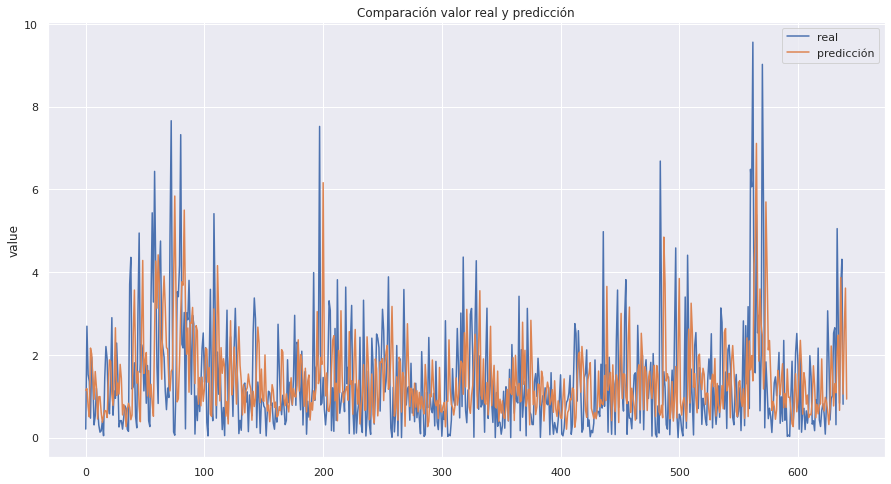

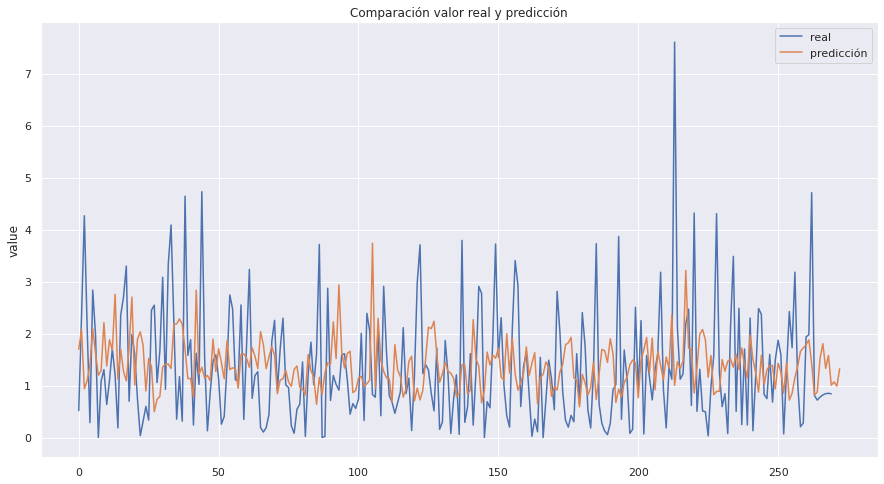

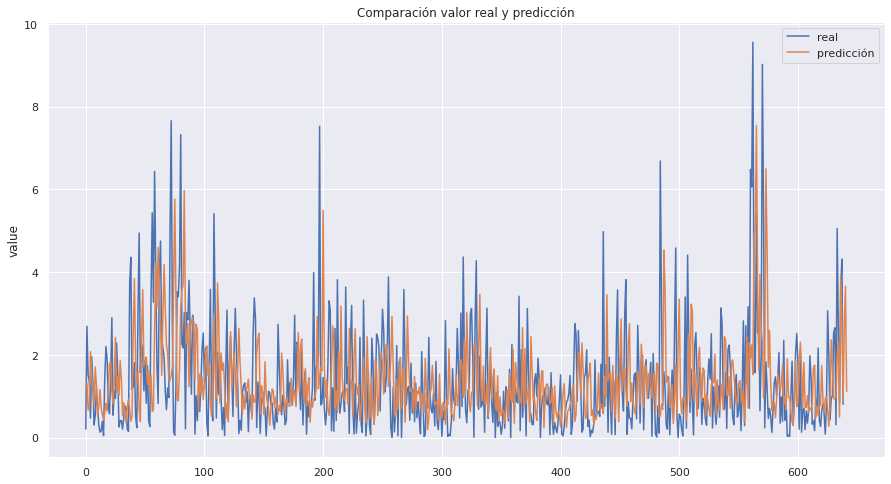

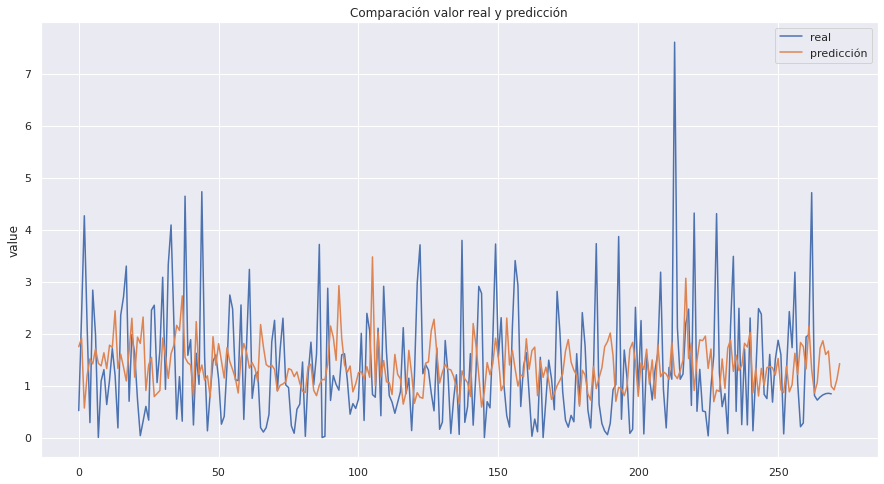

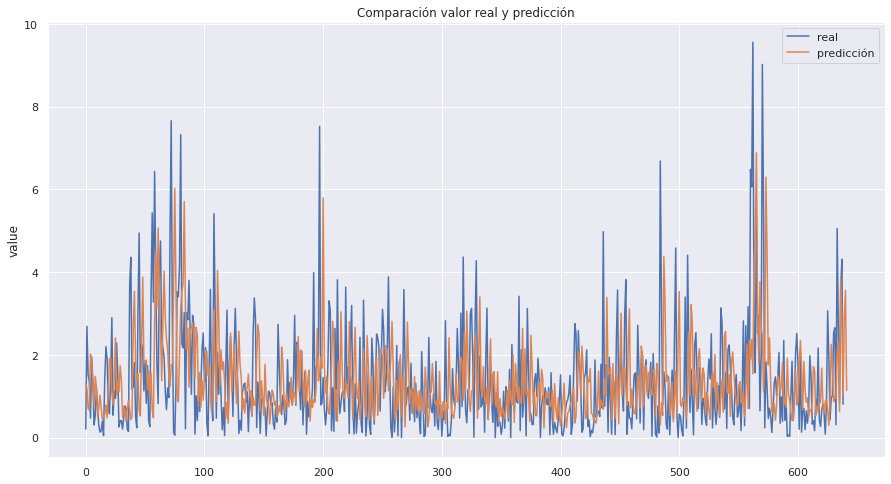

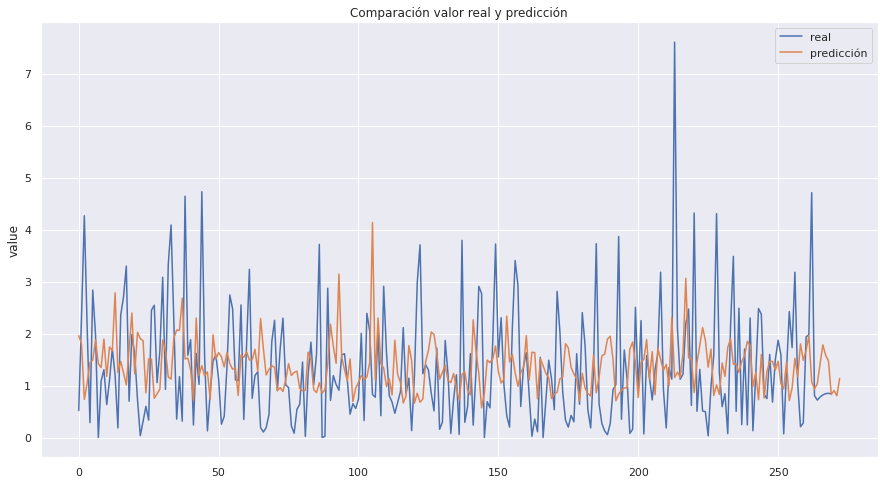

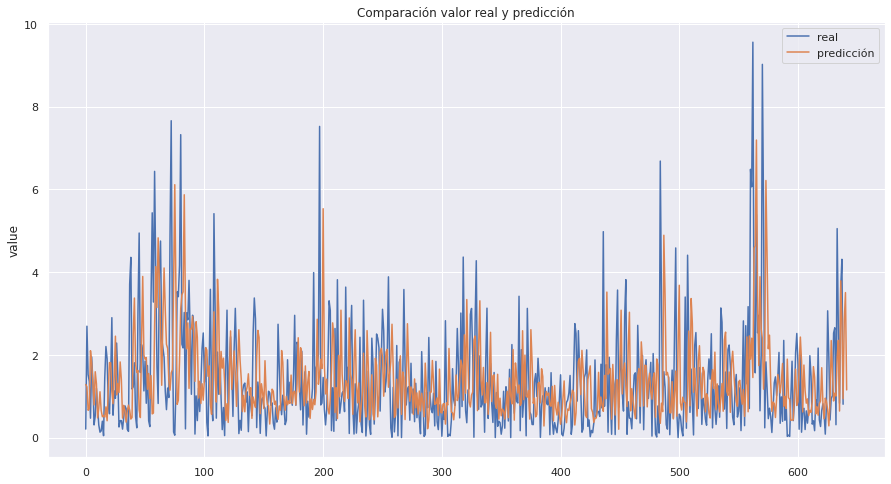

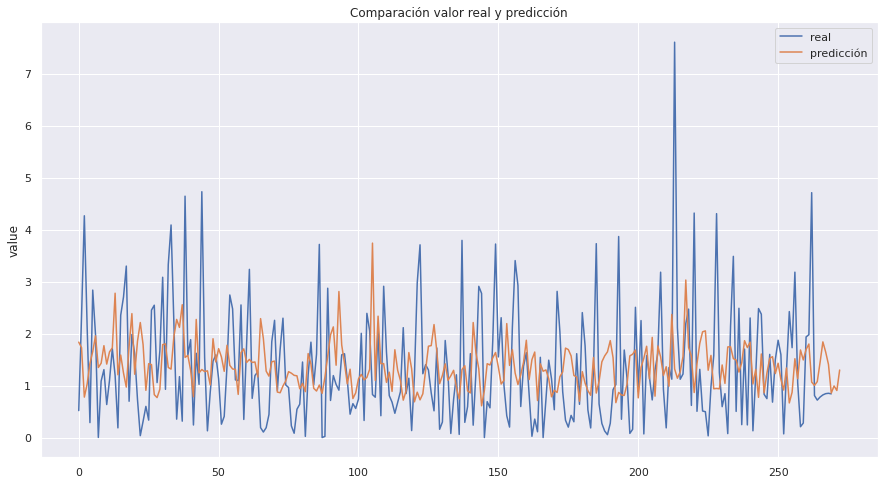

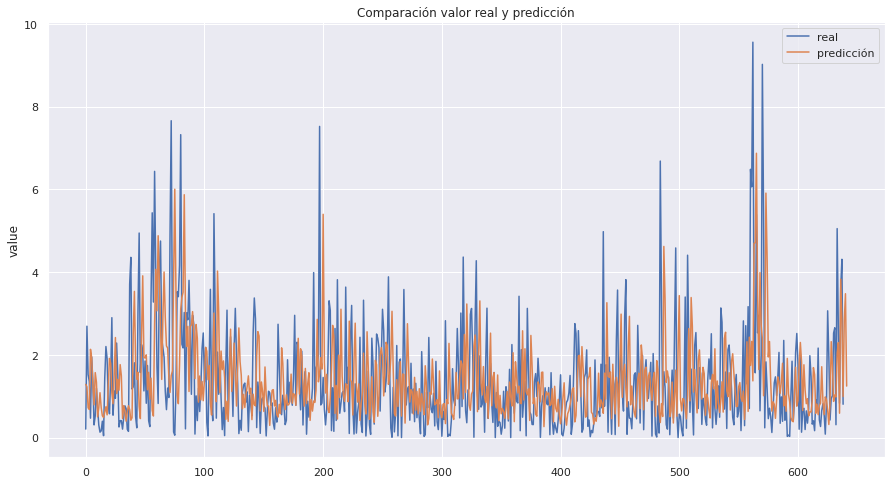

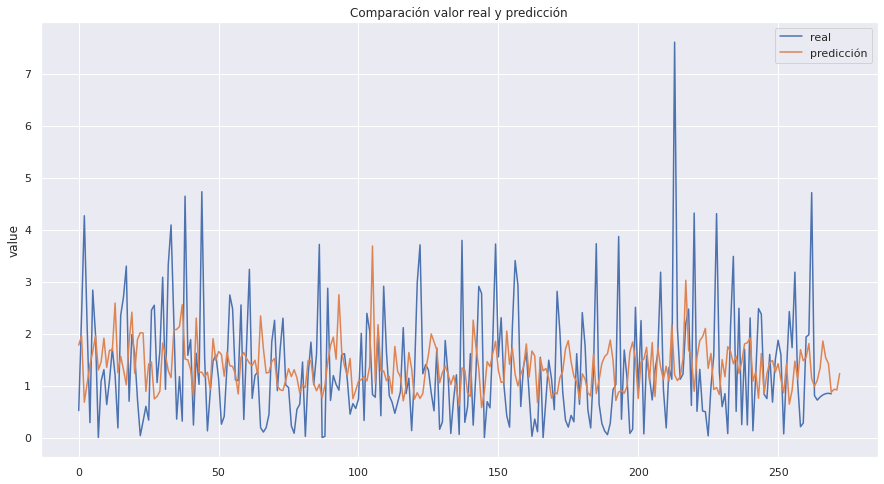

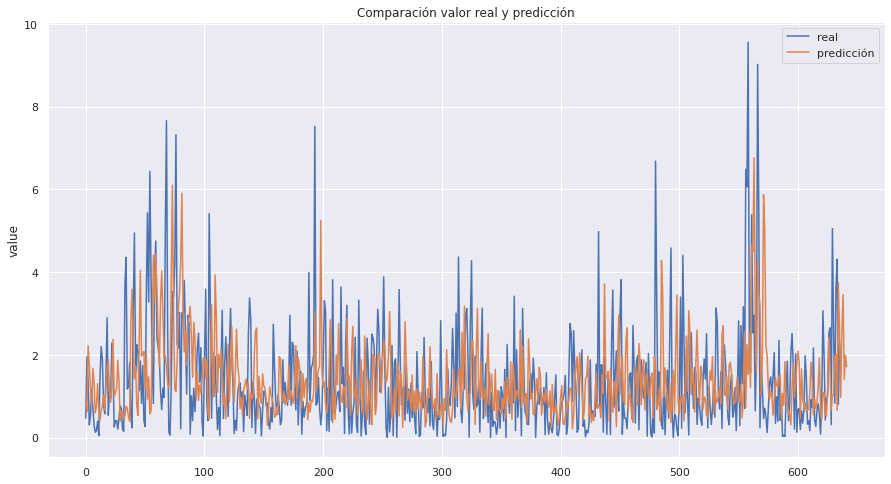

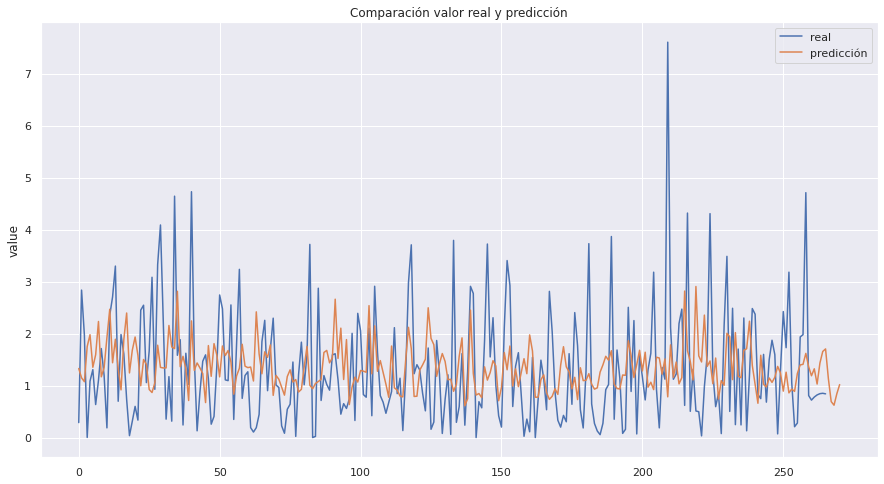

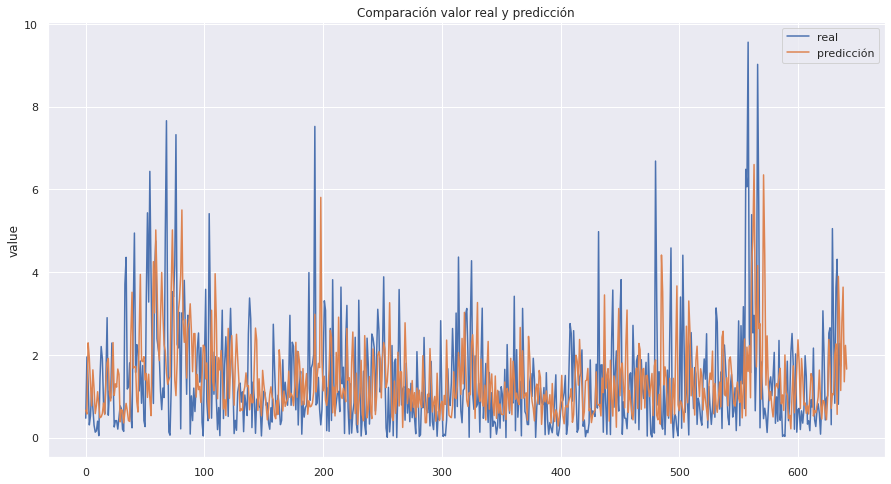

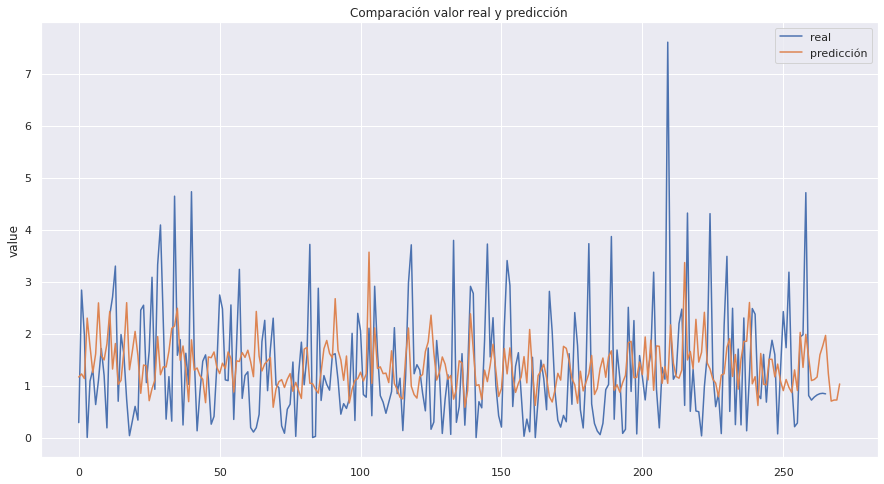

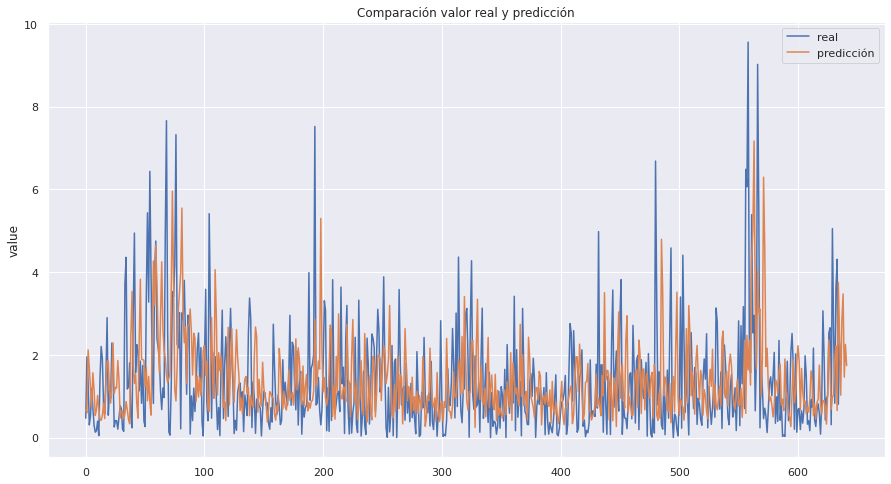

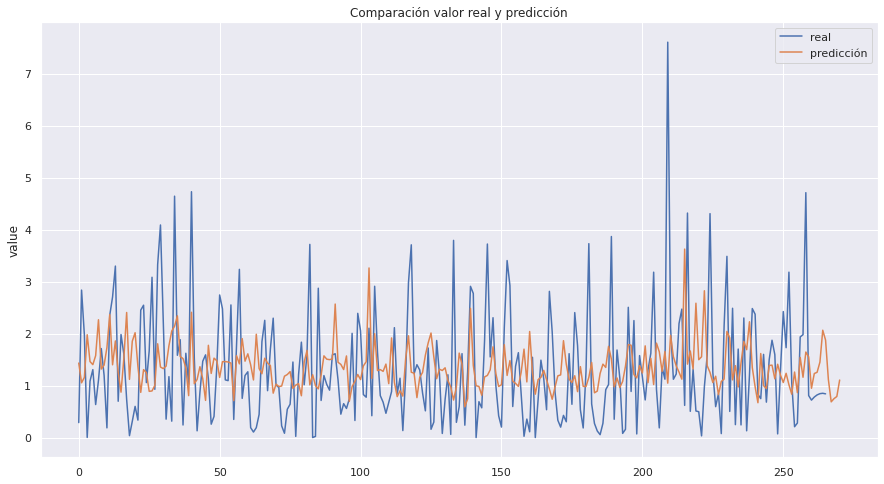

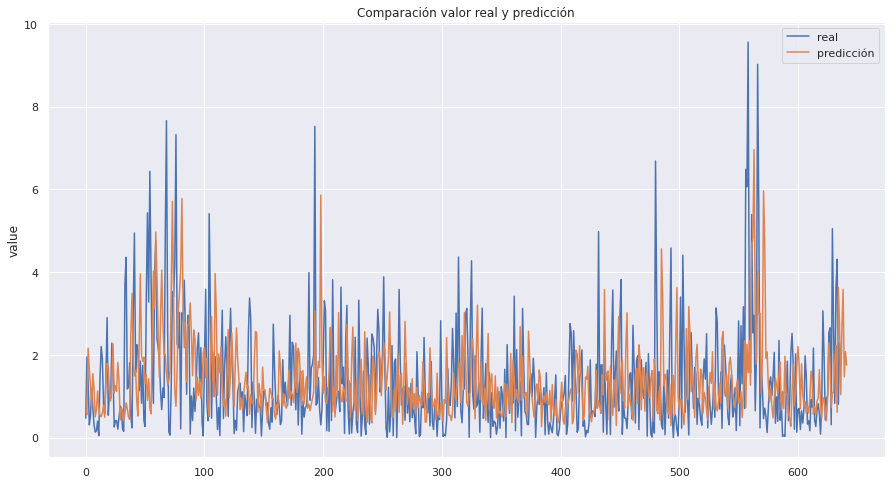

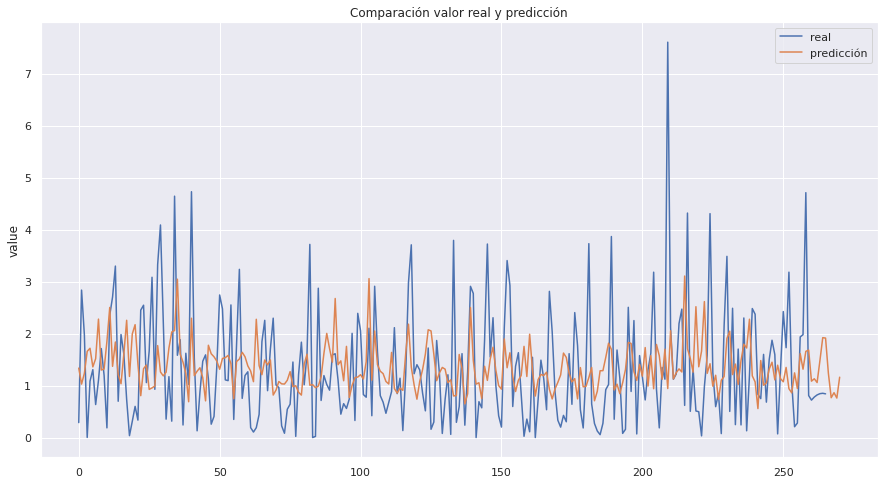

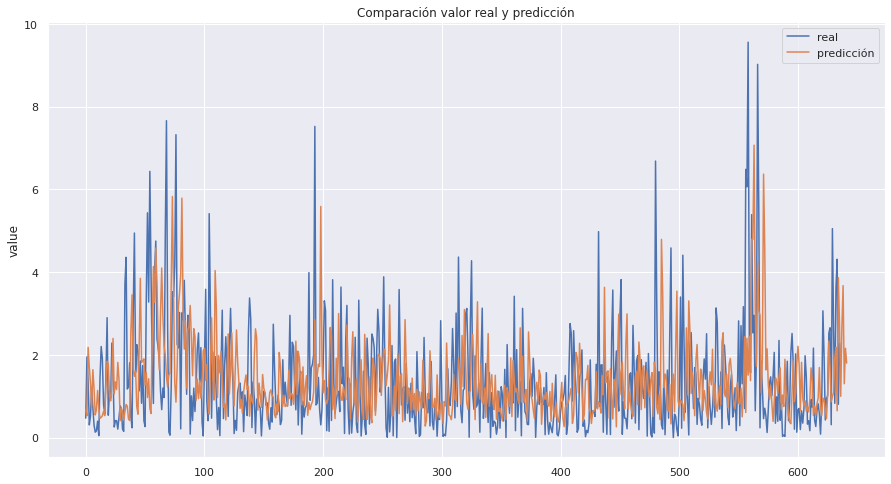

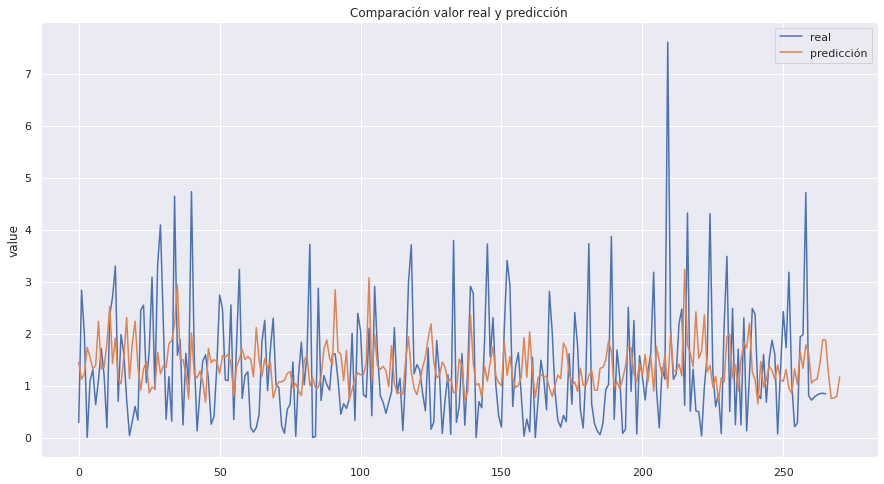

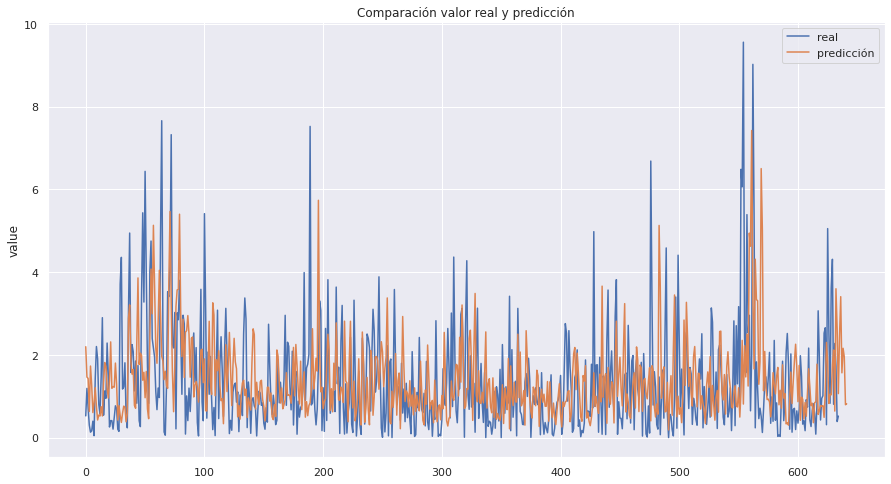

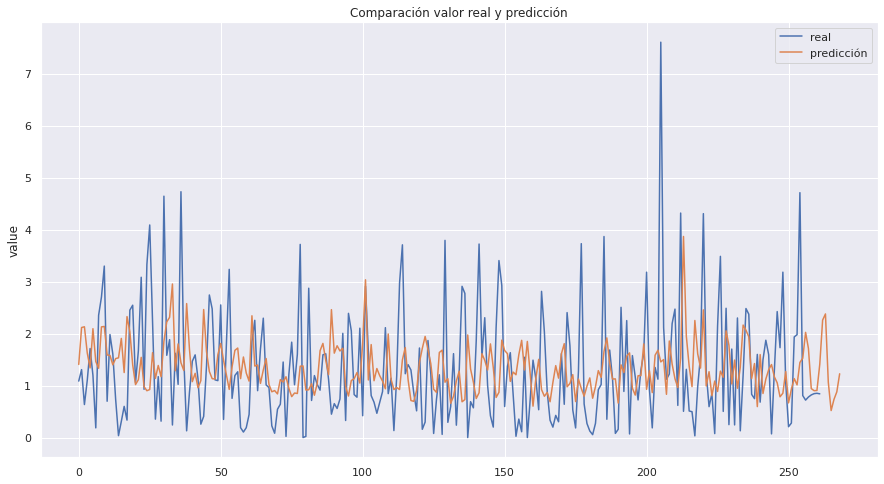

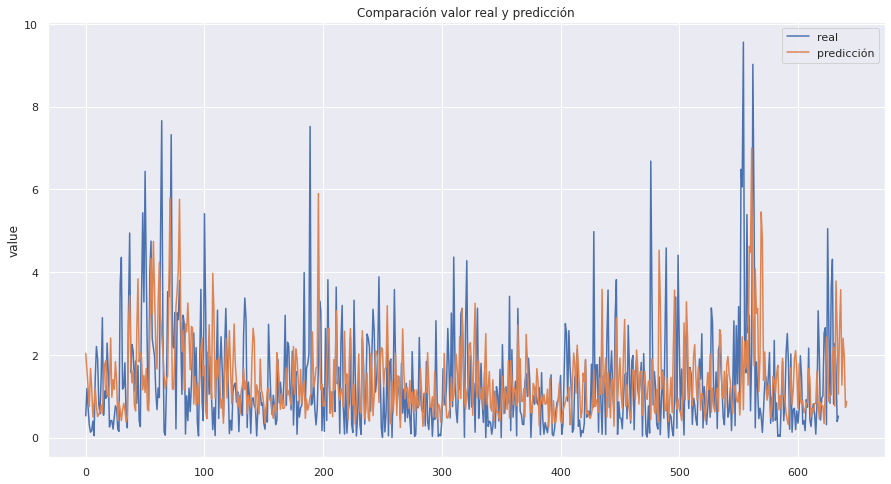

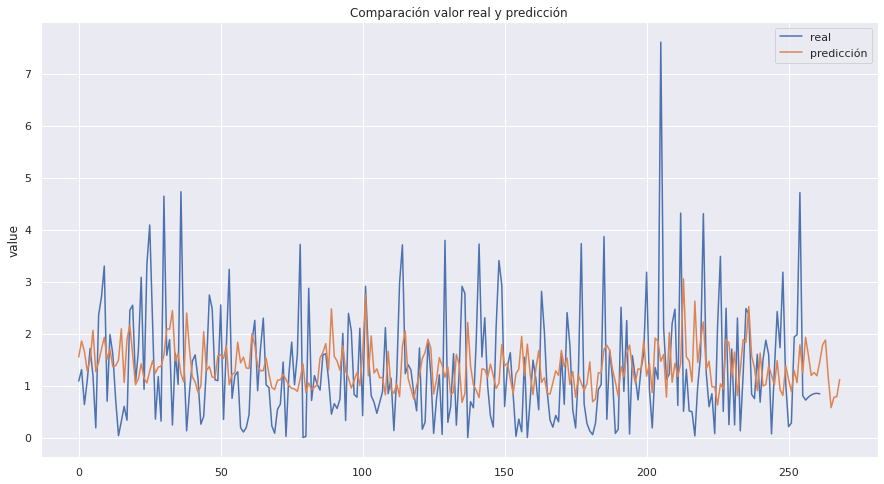

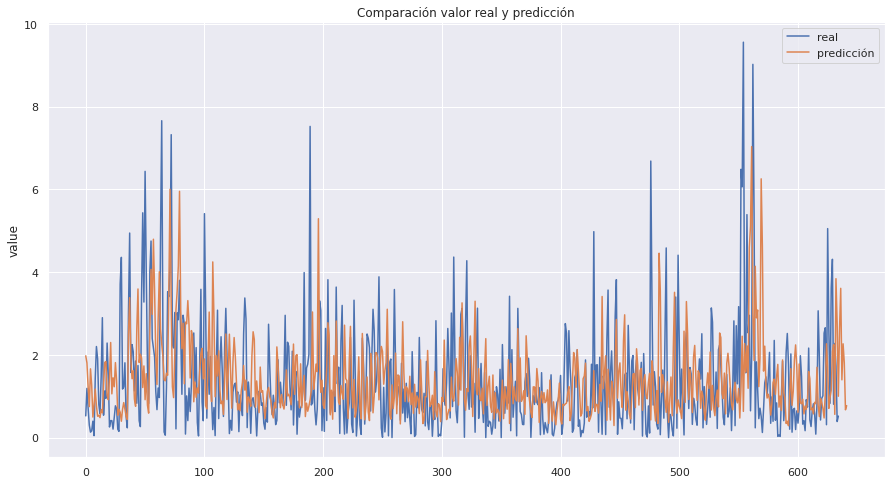

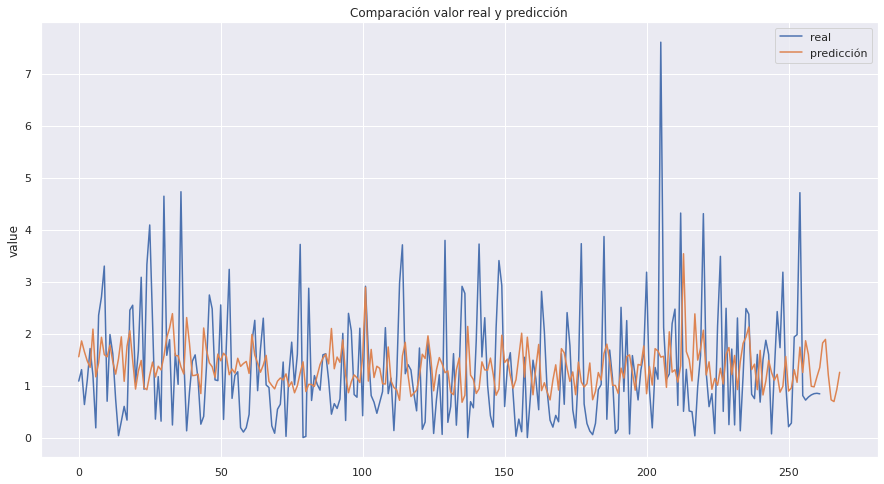

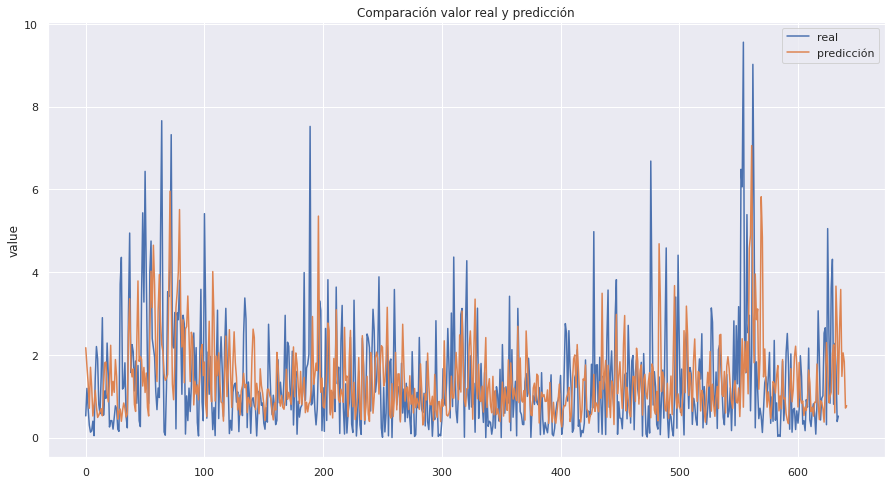

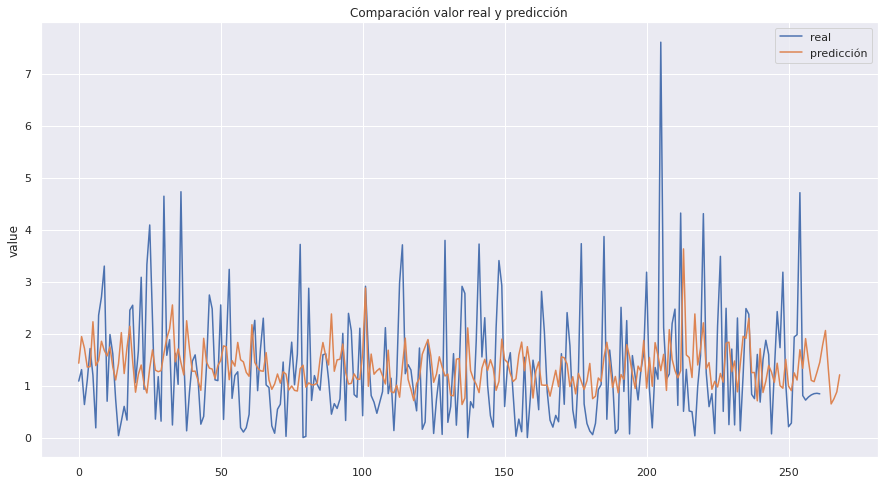

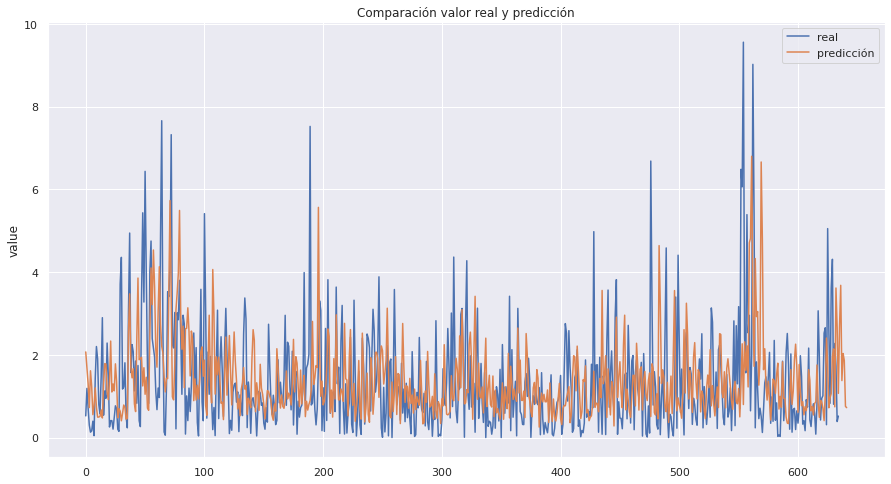

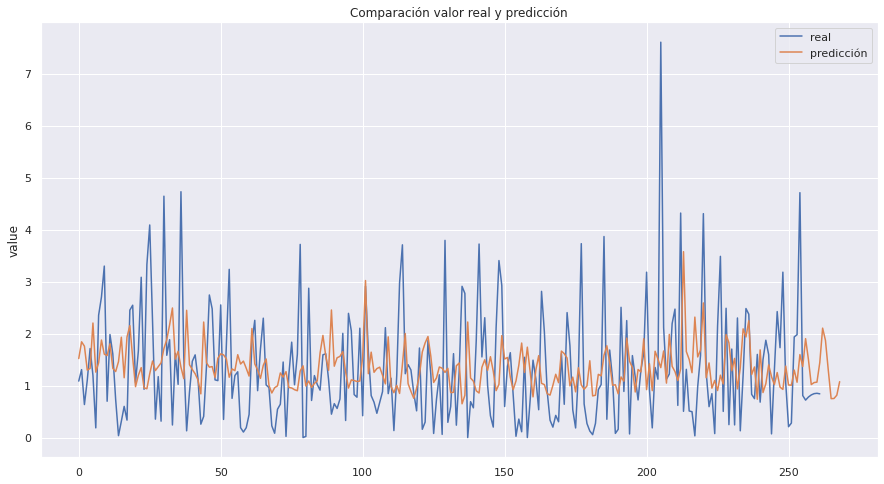

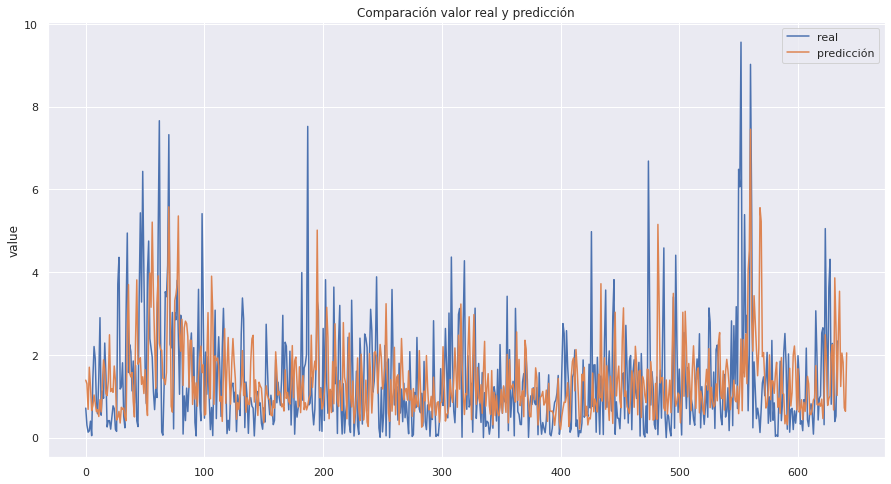

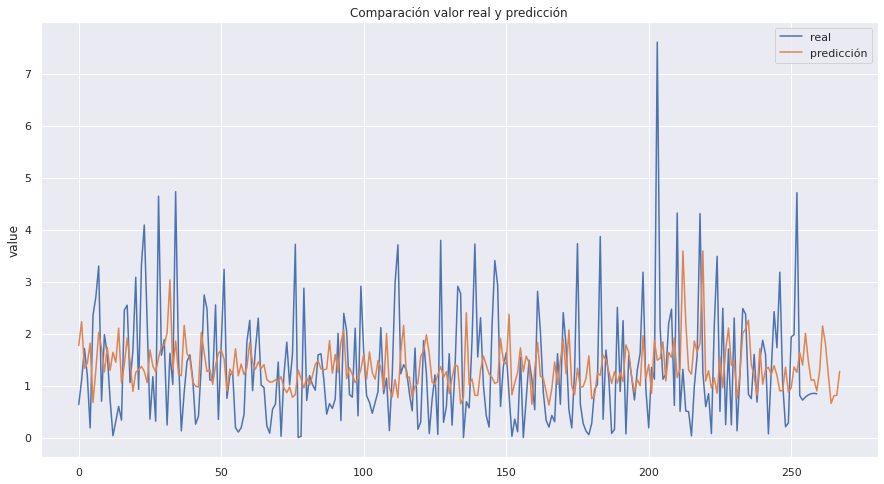

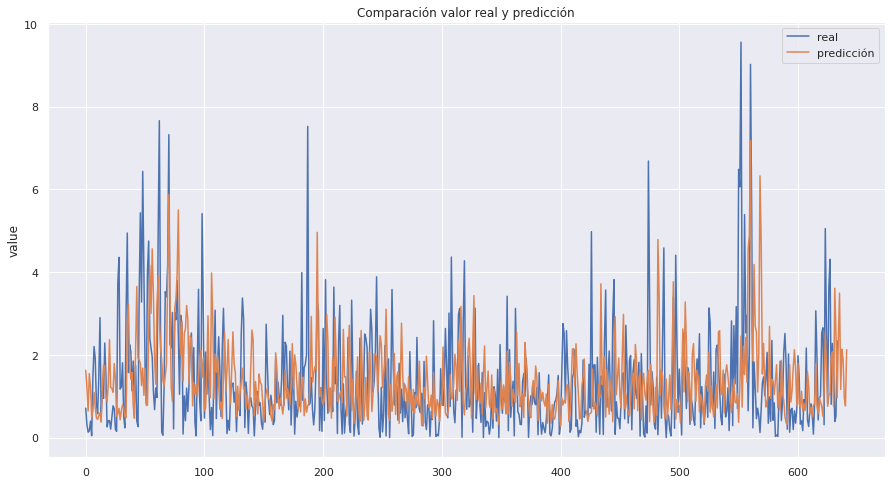

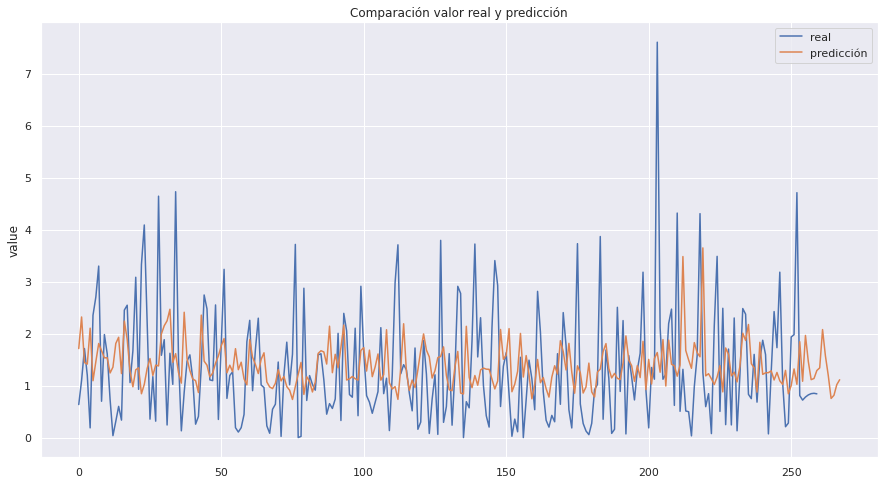

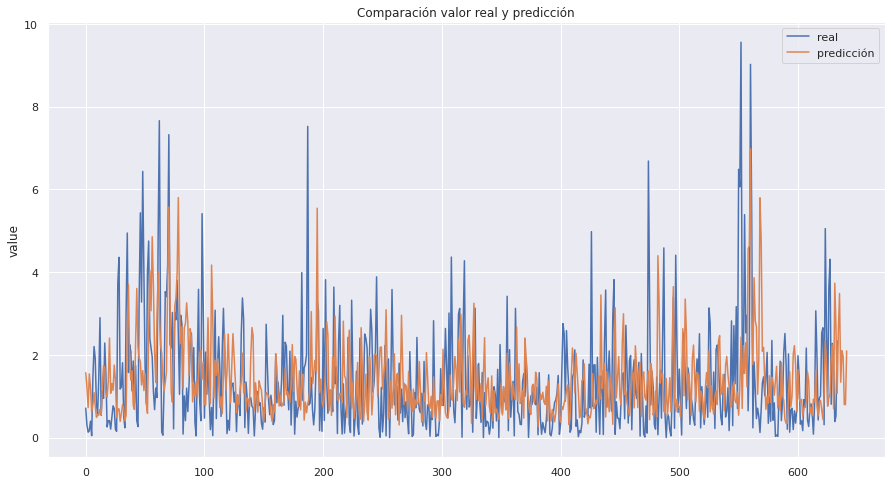

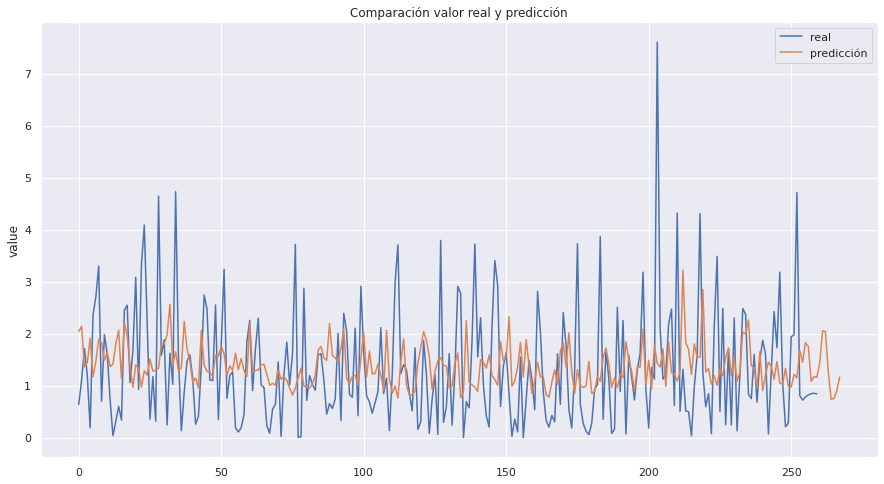

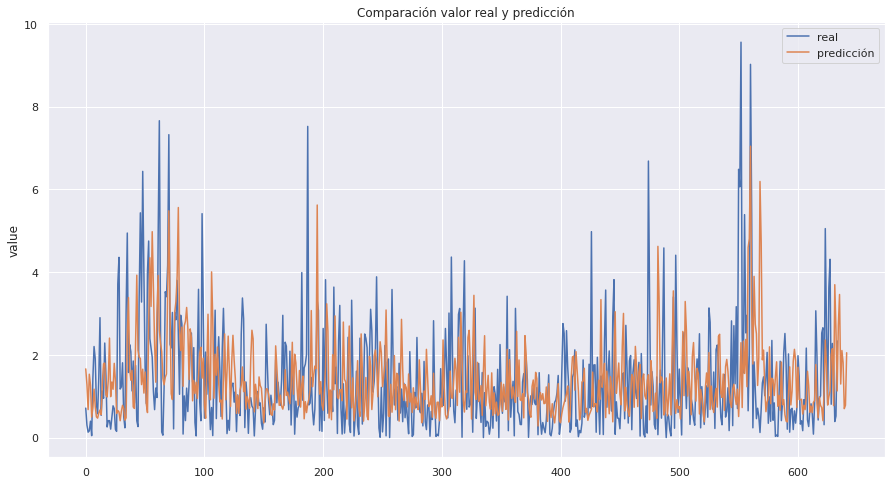

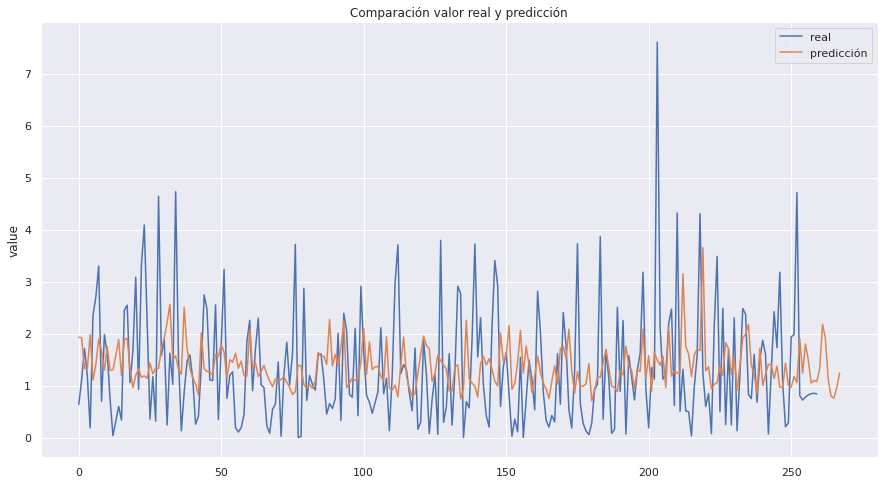

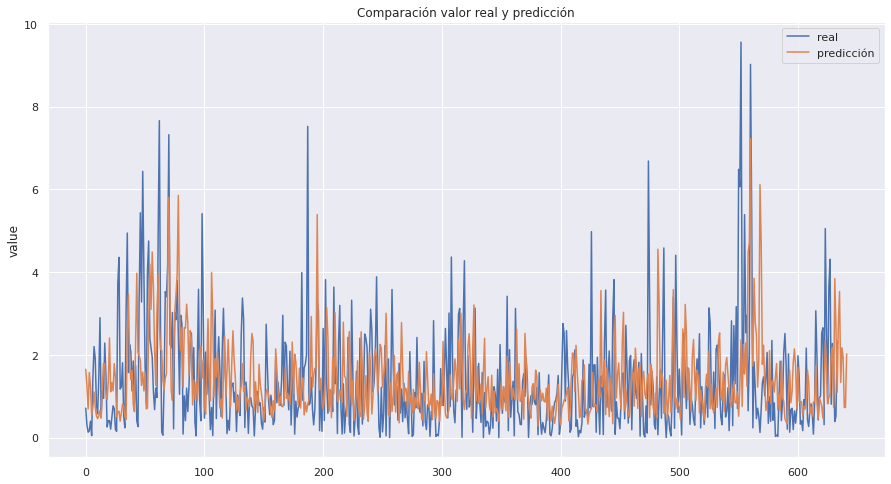

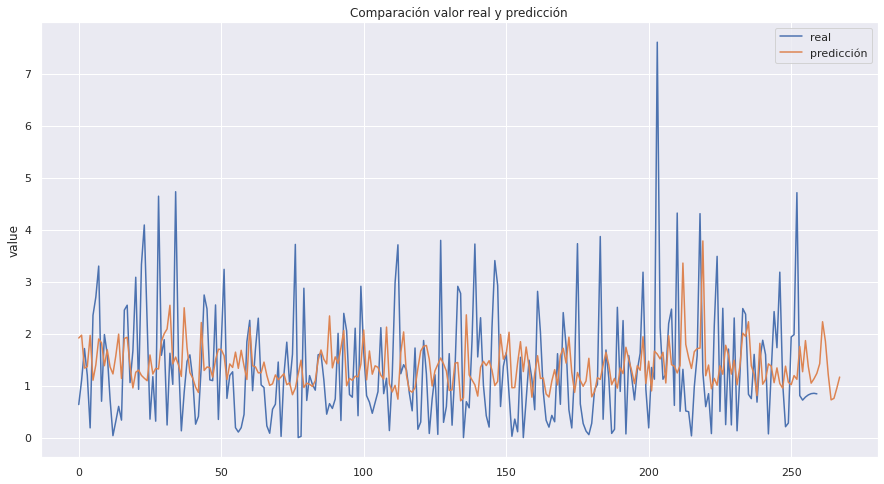

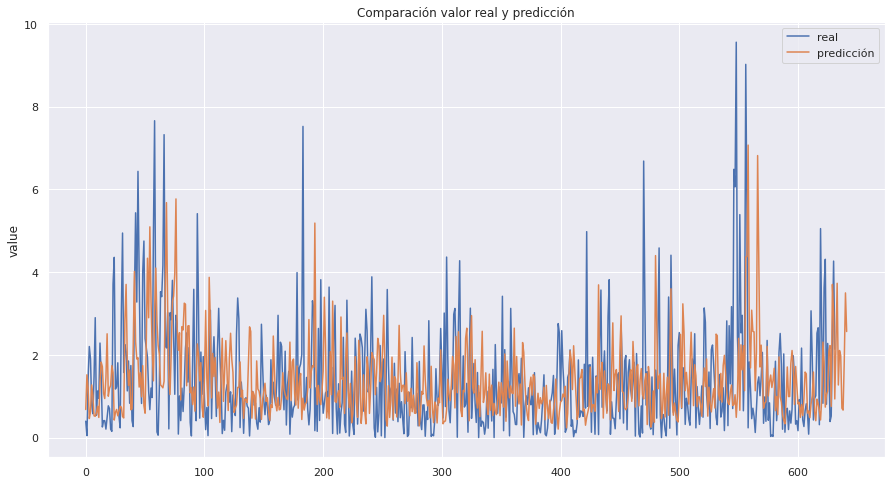

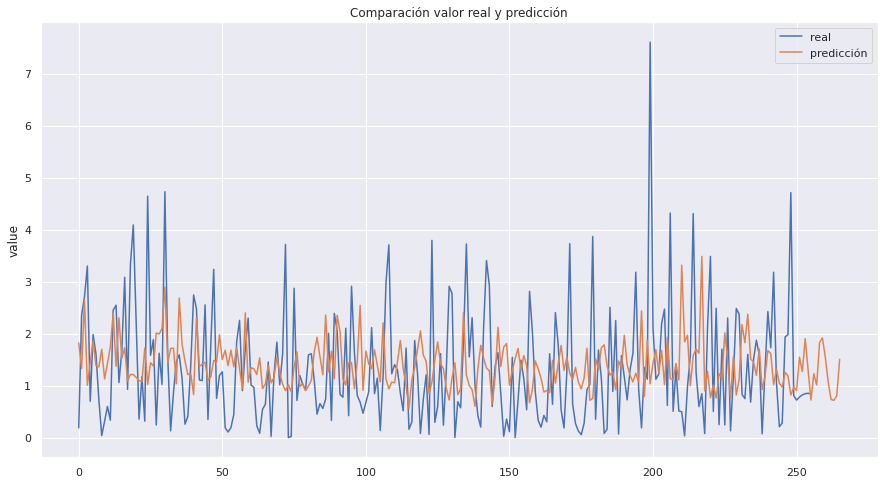

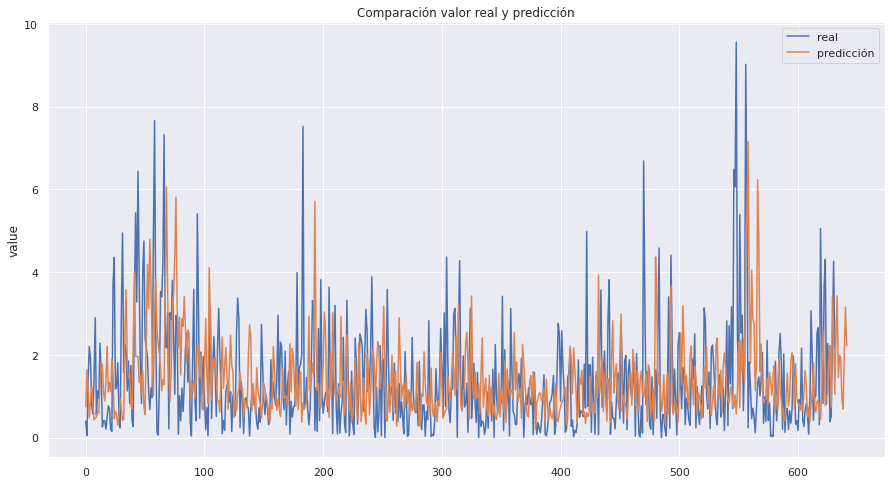

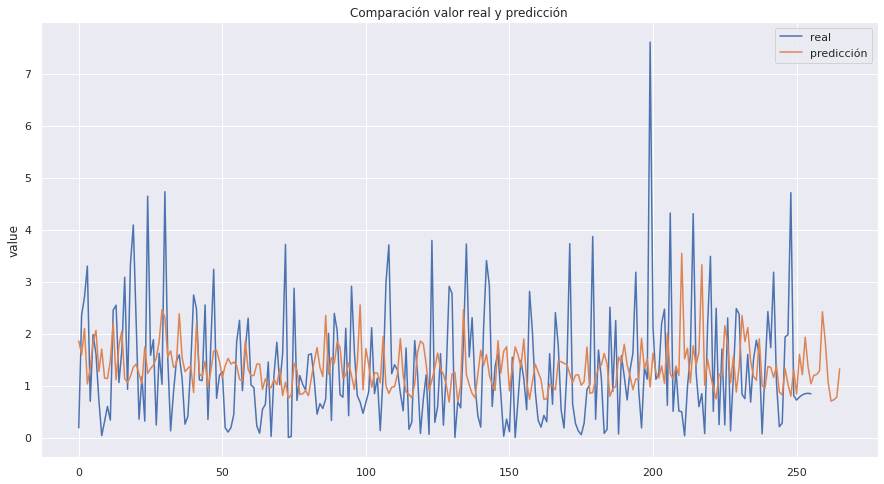

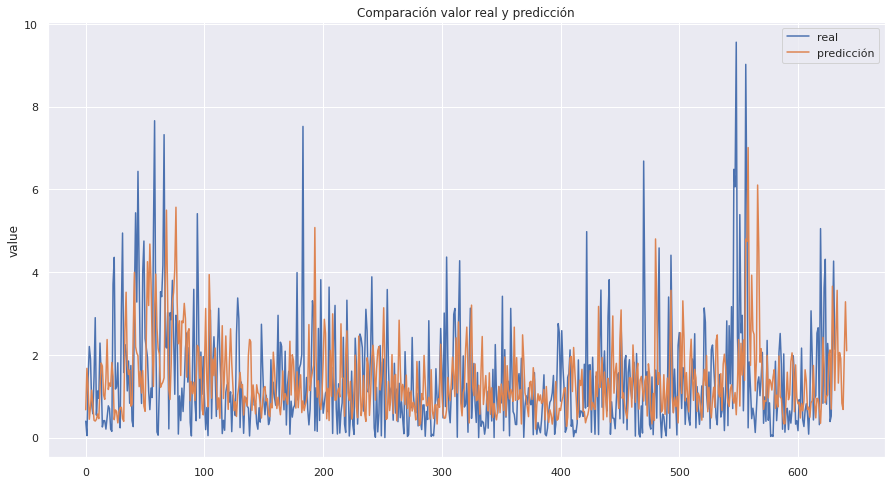

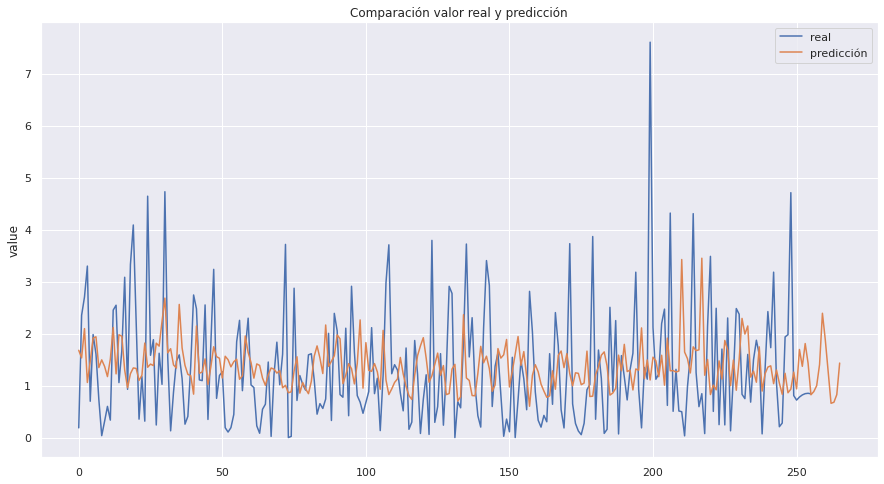

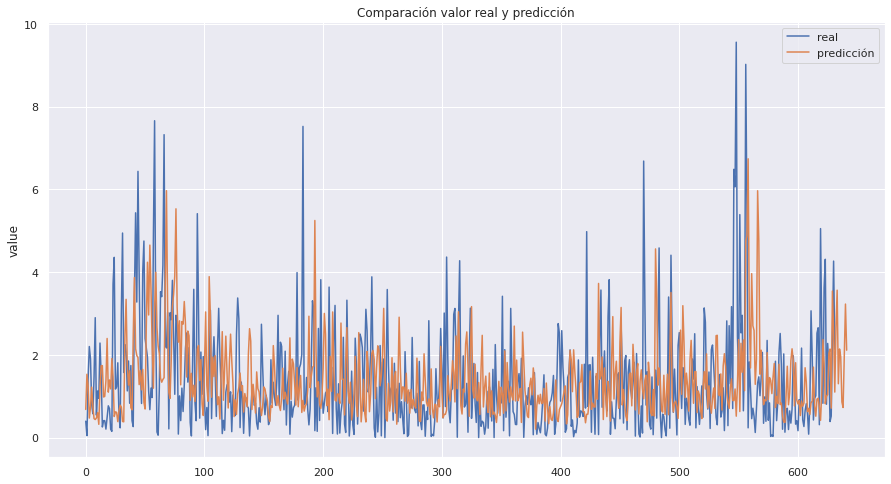

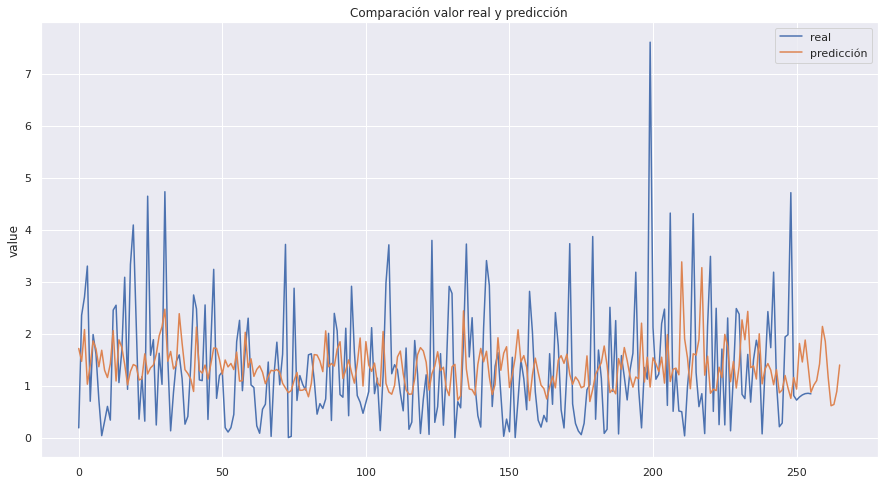

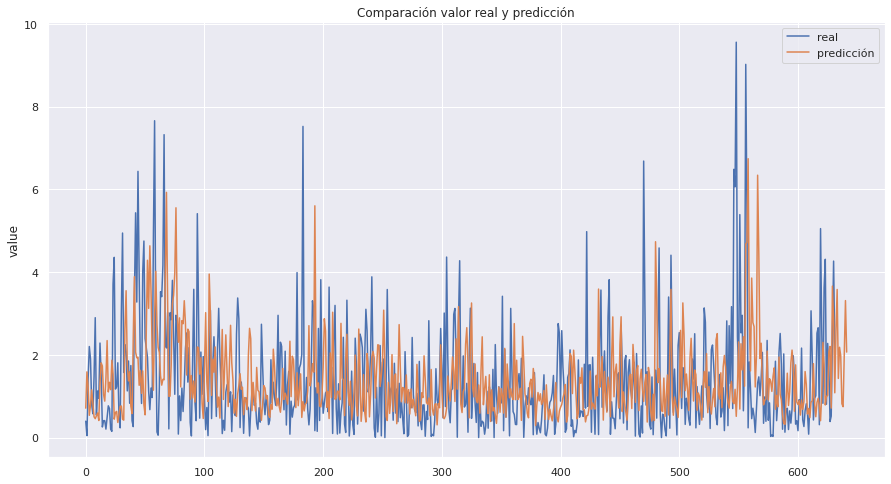

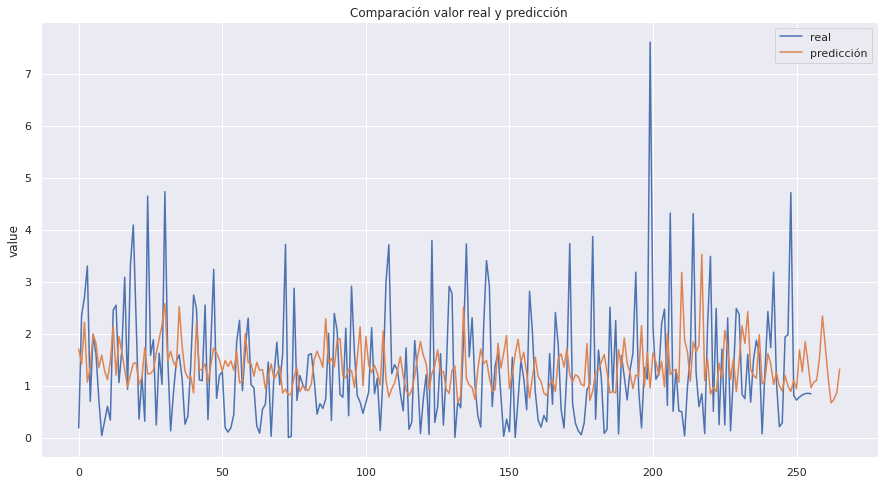

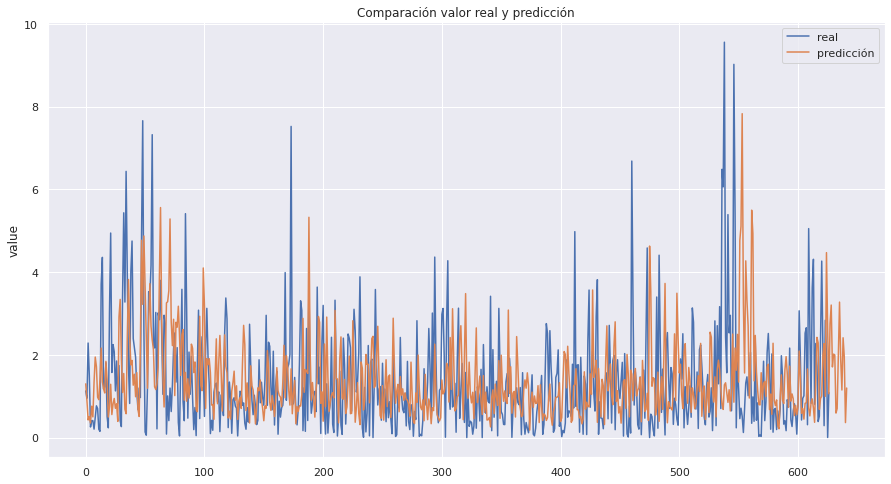

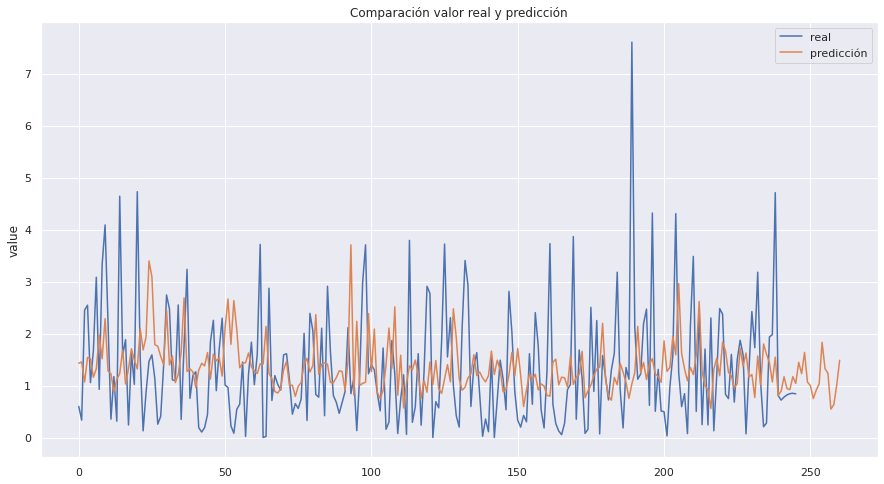

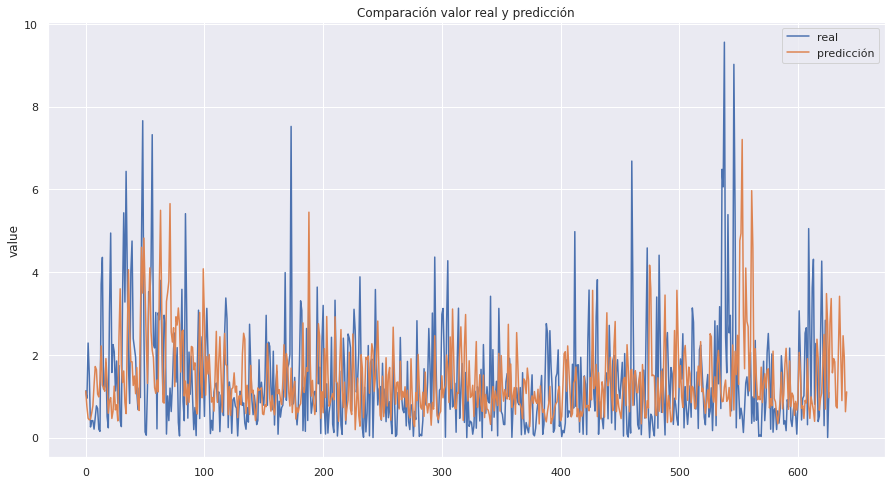

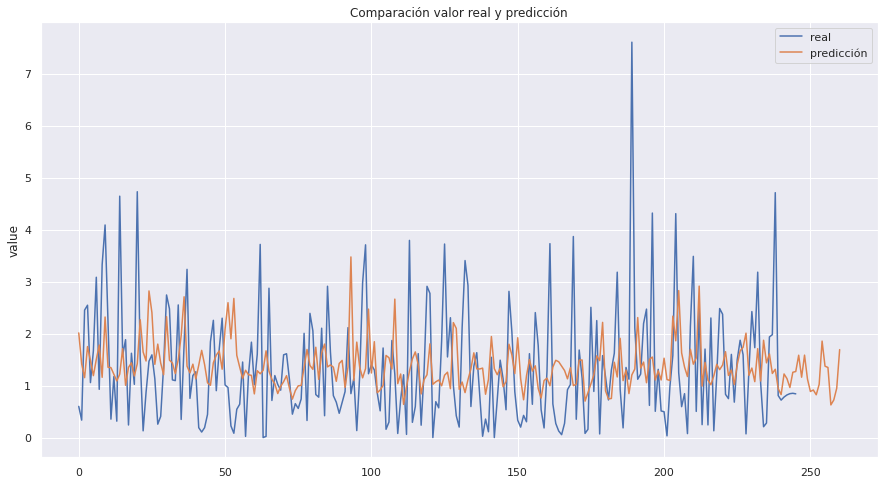

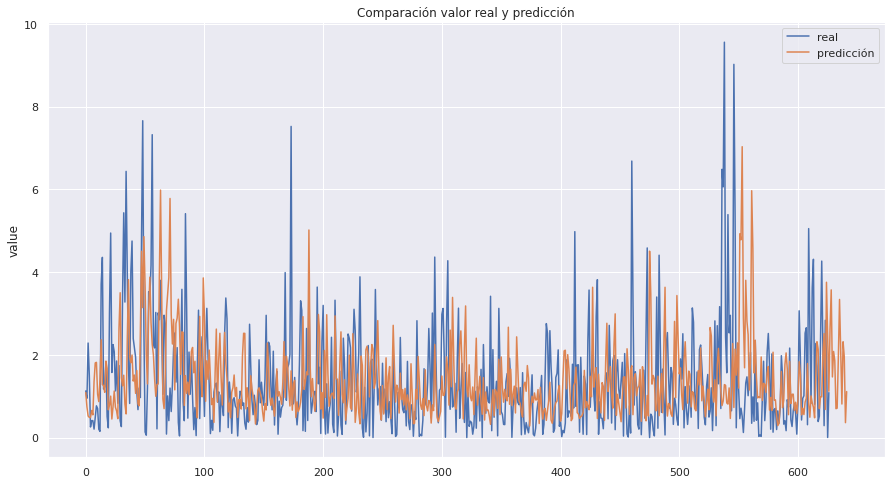

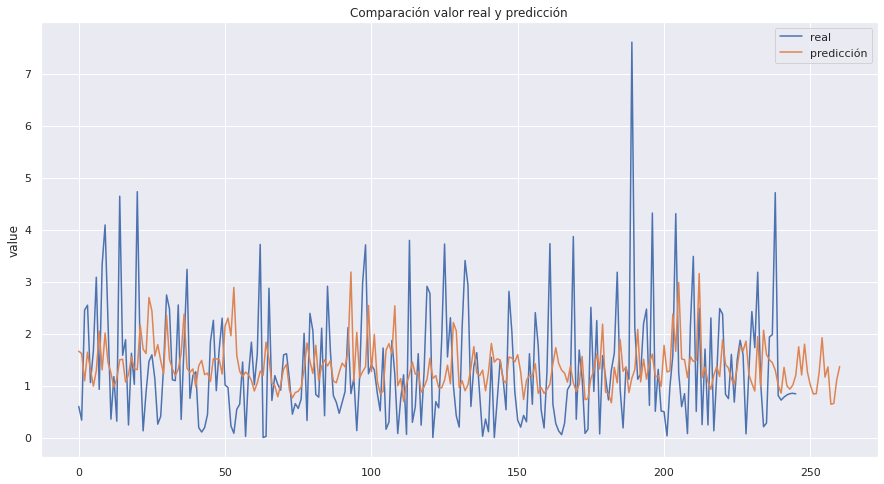

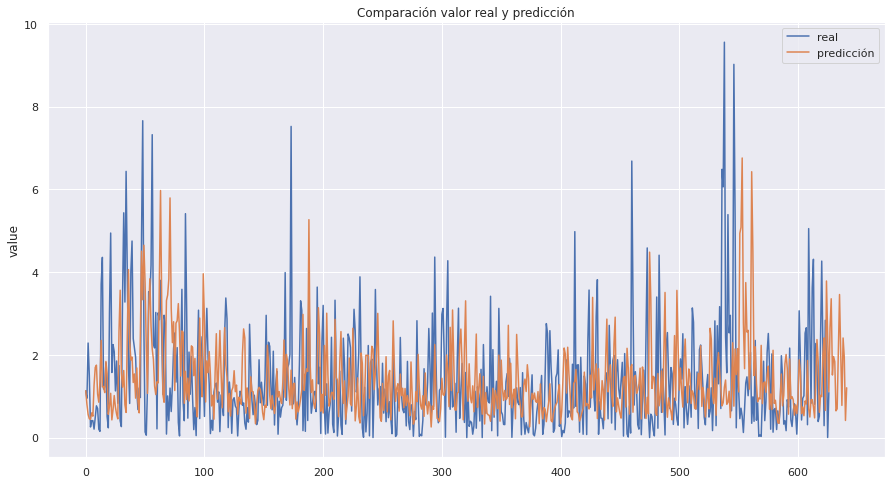

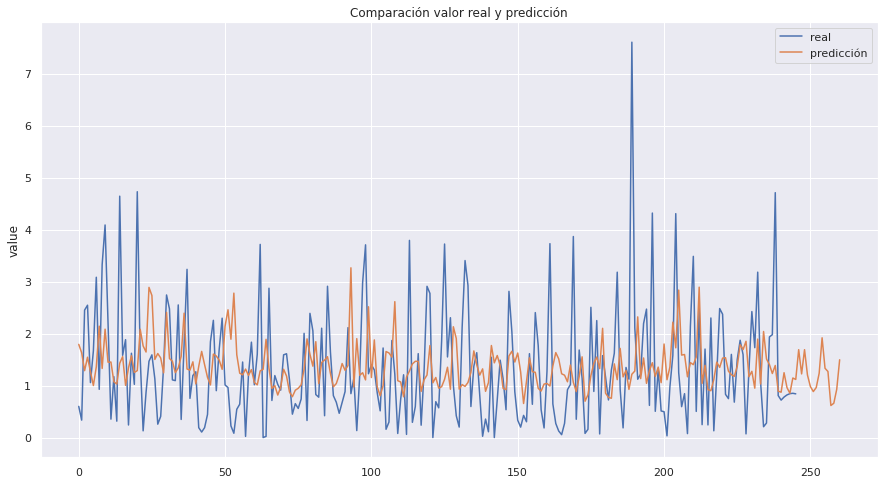

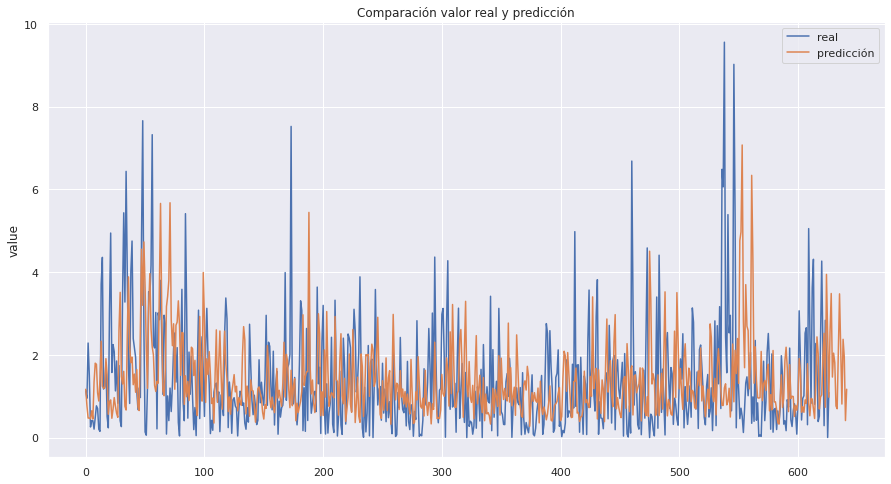

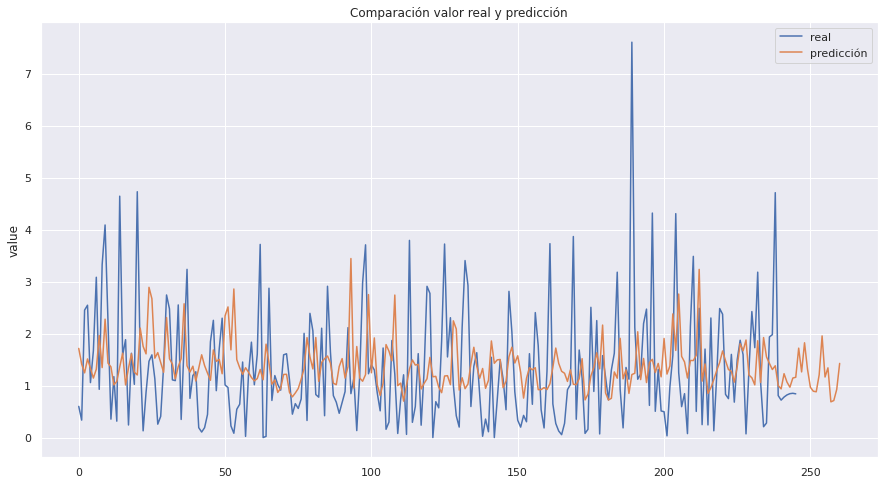

In [12]:
lags=[3,5,7,8,10,15]
n_estimators=[50,100,200,300,500]
results_models={i:{} for i in lags}
for lg in lags:
    for est in n_estimators:
        results_models[lg][est]=Model(df_data.copy(),df_label.copy(),lg,est)